In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# A model of the retina up until the retinal ganglion cells (RGCs)

In [2]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [3]:
from copy import deepcopy
import pickle
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import h5py
from jax import jit, value_and_grad, vmap
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

from jax.scipy.signal import convolve2d
import jaxley as jx
from jaxley.channels import HH
from jaxley.synapses import GlutamateSynapse

# Define setup

In [4]:
all_dfs = pd.read_pickle("results/data/setup.pkl")
cell_id = "20170610_1"
cell = jx.read_swc(f"morphologies/{cell_id}.swc", nseg=4, max_branch_len=300.0, min_radius=5.0)

is_off_bc = True  # for OFF-BCs, we compute `(1-image)` as the light stimulus, leading to an inverted bc activity.

# General hyperparameters.
num_pixels = (20, 15)
pixel_size = 30


# OPL hyperparameters.
gaussian_kernel_std = 20.0
kernel_size = 50


# BC hyperparameters.
size_multiplier_for_bc_grid_x = 0.85  # How much larger should the BC grid be, compared to one image.
size_multiplier_for_bc_grid_y = 0.6  # How much larger should the BC grid be, compared to one image.
bc_spacing = 40.0

# Define offsets for the center of the grid for BCs -- this does not influence results as long
# as the BC grid covers the cell.
offset_for_bc_center_x = -20.0
offset_for_bc_center_y = 10.0

soma_x = cell.xyzr[1][0, 0] - offset_for_bc_center_x
soma_y = cell.xyzr[1][0, 1] - offset_for_bc_center_y
bc_grid_start_x = soma_x - 7.5 * pixel_size * size_multiplier_for_bc_grid_x
bc_grid_start_y = soma_y - 10.0 * pixel_size * size_multiplier_for_bc_grid_y

bc_grid_size_x = 450.0 * size_multiplier_for_bc_grid_x  # um
bc_grid_size_y = 600.0 * size_multiplier_for_bc_grid_y  # um

# Outer plexiform layer: a linear filter

In [5]:
def center_surround_filter(spatial_axis, std1=50, std2=200):
    amp1 = 1 / std1
    gaussian1 = amp1 * np.exp(-spatial_axis**2 / std1**2)
    
    amp2 = 1 / std2
    gaussian2 = amp2 * np.exp(-spatial_axis**2 / std2**2)
    
    spatial_kernel = gaussian1 - gaussian2
    return spatial_kernel


def gaussian_filter(spatial_axis, std=50):
    amp1 = 1 / std
    gaussian1 = amp1 * np.exp(-spatial_axis**2 / std**2)
    return gaussian1


# spatial_axis = np.linspace(-600, 600, 1000)
# center_surround_kernel = center_surround_filter(spatial_axis)
# gaussian_kernel = gaussian_filter(spatial_axis)

# fig, ax = plt.subplots(1, 2, figsize=(6, 2))
# _ = ax[0].plot(spatial_axis, center_surround_kernel)
# _ = ax[1].plot(spatial_axis, gaussian_kernel)

In [6]:
def upsample_image(image, pixel_size, kernel_size):
    """Returns a new image where every value is one micro meter in size."""
    image = np.repeat(image, (pixel_size,), axis=0)
    image = np.repeat(image, (pixel_size,), axis=1)
    image_full = np.zeros((image.shape[0] + 2*kernel_size - 1, image.shape[1] + 2*kernel_size - 1))
    image_full[kernel_size:-kernel_size+1,kernel_size:-kernel_size+1] = image 
    return image_full

In [7]:
def build_opl_kernel(filter: str, std, filter_size):
    res_filter = 100
    center = [0., 0.]
    
    pos_x = np.linspace(-filter_size, filter_size, res_filter)
    pos_y = np.linspace(-filter_size, filter_size, res_filter)
    X, Y = np.meshgrid(pos_x, pos_y)
    
    dist_x = center[0] - X
    dist_y = center[1] - Y
    
    dists = np.sqrt(dist_x**2 + dist_y**2)

    if filter == "Gaussian":
        kernel = gaussian_filter(dists, std) / 100.0
    elif filter == "center_surround":
        raise NotImplementedError
        kernel = center_surround_filter(dists) / 100.0
    else:
        raise ValueError

    return kernel

def opl(image, kernel):
    """Performs linear spatial filtering with a provided kernel."""
    bc_input = convolve2d(image, kernel, mode="valid")
    return bc_input

# Bipolar cell: input output mapping

Values grabbed from Schwartz et al. 2012, Fig 7c.

In [8]:
class BipolarCell:
    """Given input current, return output of bipolar cells."""

    def __init__(self, max_input):
        self.x_vals = [-100, -50, -25, -12.5, -6.75, -3, 3, 6.75, 12.5, 25.0, 50.0, 100.0]
        self.response = [-0.05, -0.12, -0.15, -0.1, -0.08, -0.03, 0.1, 0.18, 0.37, 0.64, 0.85, 1.0]
        self.intensity = (1.0 + 1.0 / 100 * np.asarray(self.x_vals)) / 2.0

        # To scale the input-output curve, we have to know the maximal input current.
        self.max_input = max_input

    def __call__(self, input):
        standardized_bc_input = input / self.max_input
        bc_output = np.interp(standardized_bc_input, self.intensity, self.response)
        return bc_output

# Build Bipolar cell grid helpers

In [9]:
def get_bc_cell_locations(spacing, bc_grid_size_x, bc_grid_size_y):
    """Return x- and y-location of BCs at origin zero.
    
    Args:
        spacing: Distance between BCs (in um).
    """
    gap_x = spacing
    gap_y = np.sqrt(gap_x ** 2 - (gap_x/2) **2)
    x_locs = np.arange(0, bc_grid_size_x, gap_x)
    y_locs = np.arange(0, bc_grid_size_y, gap_y)
    
    all_x_locs, all_y_locs = np.meshgrid(x_locs, y_locs)
    all_x_locs[::2] += gap_x / 2
    
    all_x_locs = all_x_locs.flatten()
    all_y_locs = all_y_locs.flatten()

    return all_x_locs, all_y_locs


def move_bc_locations(x_loc_bipolar, y_loc_bipolar, x_move, y_move):
    """Move the locations of the bipolar cells to the image center."""
    # TODO: need to move it to the center of the cell, and the grid of BCs has to cover the whole space.
    bc_loc_x = x_loc_bipolar + x_move
    bc_loc_y = y_loc_bipolar + y_move
    return bc_loc_x, bc_loc_y


def get_image_locs(df):
    im_pos_x = np.linspace(-7.5*pixel_size + 0.5, 7.5*pixel_size - 0.5, 15*pixel_size) + df["image_center_x"].item()
    im_pos_y = -np.linspace(-10.0*pixel_size + 0.5, 10.0*pixel_size - 0.5, 20*pixel_size) + df["image_center_y"].item()
    return im_pos_x, im_pos_y


def discretize_bc_output(bc_output, bc_loc_x, bc_loc_y, im_pos_x, im_pos_y):
    """Given the (almost continuous) BC output grid, compute the position of BC cells."""
    pixel_size = 30  # um
    
    grid_x, grid_y = np.meshgrid(im_pos_x, im_pos_y)
    
    dists = []
    output_vals_at_bc_loc = []
    
    for x, y in zip(bc_loc_x, bc_loc_y):
        dist_x = (grid_x - x)**2
        dist_y = (grid_y - y)**2
        dist = np.sqrt(dist_x + dist_y)
        min_ind = np.unravel_index(np.argmin(dist), dist.shape)
        dists.append(min_ind)
        output_vals_at_bc_loc.append(bc_output[min_ind])
    
    dists = np.asarray(dists)
    
    # Standardize to [0, 1] range.
    output_vals_at_bc_loc = output_vals_at_bc_loc - np.min(output_vals_at_bc_loc)
    output_vals_at_bc_loc = output_vals_at_bc_loc / np.max(output_vals_at_bc_loc)

    return output_vals_at_bc_loc

# Run all scan fields

In [14]:
# rec_id = 1
for rec_id in range(3, 9):
    print(f"Rec id {rec_id}")
    roi_id = 1  # Does not matter.

    # Read image information.
    df = all_dfs[all_dfs["cell_id"] == cell_id]
    df = df[df["rec_id"] == rec_id]
    df = df[df["roi_id"] == roi_id]
    im_pos_x, im_pos_y = get_image_locs(df)

    # Read stimulus information.
    file = h5py.File("data/noise3.h5", 'r+')
    noise_stimulus = file["k"][()]

    if is_off_bc:
        noise_stimulus = 1.0 - noise_stimulus

    # PR and BC instantiation.
    opl_kernel = build_opl_kernel(filter="Gaussian", std=gaussian_kernel_std, filter_size=kernel_size)
    max_of_bc_inputs = np.max(opl(np.ones((200, 200)), opl_kernel))
    BC = BipolarCell(max_of_bc_inputs)

    # Build grid of BCs.
    bc_loc_x_origin_0, bc_loc_y_origin_0 = get_bc_cell_locations(bc_spacing, bc_grid_size_x, bc_grid_size_y)
    bc_loc_x, bc_loc_y = move_bc_locations(bc_loc_x_origin_0, bc_loc_y_origin_0, bc_grid_start_x, bc_grid_start_y)


    activities_across_time = []
    for time_point in range(noise_stimulus.shape[2]):
        image = noise_stimulus[:, :, time_point].T

        # OPL and IPL.
        upsampled_image = upsample_image(image, pixel_size, kernel_size)
        bc_input = opl(upsampled_image, opl_kernel)
        bc_output = BC(bc_input)

        # Assign BCs the corresponding activity.
        bipolar_cell_activity = discretize_bc_output(bc_output, bc_loc_x, bc_loc_y, im_pos_x, im_pos_y)
        activities_across_time.append(bipolar_cell_activity)

    activities_across_time = np.asarray(activities_across_time).T


    # Save as bipolar cell output.
    bipolar_cell = pd.DataFrame().from_dict({"cell_id": cell_id, "rec_id": rec_id, "bc_id": np.arange(1, len(bc_loc_x)+1), "x_loc": bc_loc_x, "y_loc": bc_loc_y, "activity": activities_across_time.tolist()})
    bipolar_cell.to_pickle(f"results/data/off_bc_output_rec_id_{cell_id}_{rec_id}.pkl")

Rec id 3
Rec id 4
Rec id 5
Rec id 6
Rec id 7
Rec id 8


### Merge all disk-written results

In [15]:
dfs = []
for rec_id in range(1, 9):
    df = pd.read_pickle(f"results/data/off_bc_output_rec_id_{cell_id}_{rec_id}.pkl")
    dfs.append(df)

dfs = pd.concat(dfs)
dfs.to_pickle(f"results/data/off_bc_output_{cell_id}.pkl")

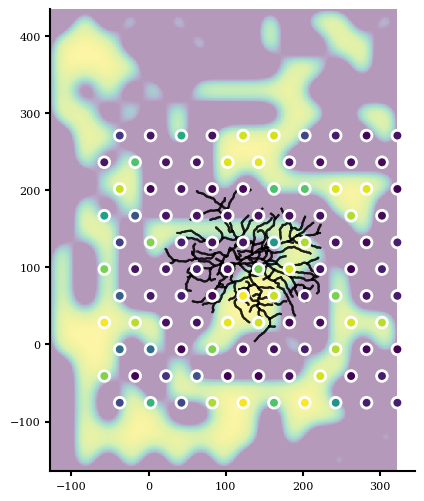

In [13]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    _ = ax.imshow(bc_output, extent=[im_pos_x[0], im_pos_x[-1], im_pos_y[-1], im_pos_y[0]], clim=[0, 1], alpha=0.4, cmap="viridis")
    
    for a, b, c in zip(bc_loc_x, bc_loc_y, bipolar_cell_activity):
        cmap = mpl.colormaps['viridis']
        _ = ax.scatter(a, b, s=40.0, color=cmap(c), zorder=10000)
        _ = ax.scatter(a, b, s=60.0, zorder=10000, facecolors='none', edgecolors='w', linewidth=2.0)
    
    ax = cell.vis(ax=ax, morph_plot_kwargs={"alpha": 0.4})
    # plt.savefig("results/figs/rgc_within_bc_grid.png", dpi=200, bbox_inches="tight")
plt.show()

# Visualizations

In [258]:
# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 2, figsize=(6, 3))
#     _ = ax[0].imshow(image, extent=[0, 450, 0, 600], cmap="gray")
#     _ = ax[0].imshow(opl_kernel, extent=[0, 100, 0, 100], cmap="Blues")
#     _ = ax[0].set_xlim([0, 450])
#     _ = ax[0].set_ylim([0, 600])
#     _ = ax[1].imshow(bc_input[25:-25, 25:-25], extent=[0, 450, 0, 600])
#     _ = ax[0].set_title("Light")
#     _ = ax[1].set_title("BC input")



# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(1, 0.75))
#     _ = ax.plot(BC.intensity, BC.response)
#     _ = ax.scatter(BC.intensity, BC.response)
#     _ = ax.set_xlabel("Intensity")
#     _ = ax.set_ylabel("Response")
#     # plt.savefig("results/figs/nonlinear_bc.png", dpi=200, bbox_inches="tight")



# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(11, 3))
#     _ = ax.imshow(opl_kernel, extent=[0, 100, 0, 100], cmap="Blues")
#     _ = ax.spines["bottom"].set_visible(False)
#     _ = ax.spines["left"].set_visible(False)
#     _ = ax.set_xticks([])
#     _ = ax.set_yticks([])
#     # plt.savefig("results/figs/gaussian_blog.png", dpi=200, bbox_inches="tight")



# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 3, figsize=(11, 3))
#     _ = ax[0].imshow(image, extent=[0, 450, 0, 600], cmap="Grays")
#     _ = ax[0].imshow(opl_kernel, extent=[0, 100, 0, 100], cmap="Blues")
#     _ = ax[1].imshow(bc_input, extent=[0, 450, 0, 600])
#     _ = ax[2].imshow(bc_output, extent=[0, 450, 0, 600])

#     for i in range(3):
#         _ = ax[i].set_xlim([0, 450])
#         _ = ax[i].set_ylim([0, 600])
#     _ = ax[0].set_title("Light")
#     _ = ax[1].set_title("BC input")
#     _ = ax[2].set_title("BC output")
#     for i in range(1, 3):
#         _ = ax[i].set_yticklabels([])
#     # plt.savefig("results/figs/overview.png", dpi=200, bbox_inches="tight")



# with mpl.rc_context(fname="../../.matplotlibrc"):
#     fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
#     _ = ax.imshow(bc_output, extent=[im_pos_x[0], im_pos_x[-1], im_pos_y[-1], im_pos_y[0]], clim=[0, 1], alpha=0.4, cmap="viridis")
    
#     for a, b, c in zip(bc_loc_x, bc_loc_y, bipolar_cell_activity):
#         cmap = mpl.colormaps['viridis']
#         _ = ax.scatter(a, b, s=40.0, color=cmap(c), zorder=10000)
#         _ = ax.scatter(a, b, s=60.0, zorder=10000, facecolors='none', edgecolors='w', linewidth=2.0)
    
#     ax = cell.vis(ax=ax, morph_plot_kwargs={"alpha": 0.4})
#     # plt.savefig("results/figs/rgc_within_bc_grid.png", dpi=200, bbox_inches="tight")
# plt.show()

# Temporal kernel: probably not needed because the input is constant over time

In [437]:
temporal_axis = np.linspace(0, 100, 1000)

amp = 1.0  # positive for ON-bipolar-cells, negative for OFF-bipolar cells.
b0 = 1.0  # level of residual polarisation when light stimulation has stopped.
tau_rf = 10.0

temporal_kernel = (amp * temporal_axis**2 / 2 / tau_rf**3 * np.exp(-temporal_axis / tau_rf) + b0)

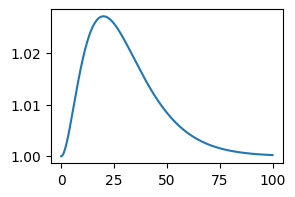

In [438]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.plot(temporal_axis, temporal_kernel)

# IPL 

In [317]:
bc_to_ac = np.zeros((5, 5))
bc_to_ac[[2, 2, 2], [1, 2, 3]] = 1.0
bc_to_ac[[1, 2, 3], [2, 2, 2]] = 1.0

ac_to_bc = np.zeros((5, 5))
ac_to_bc[[2, 2, 2, 2, 2], [0, 1, 2, 3, 4]] = 1.0
ac_to_bc[[0, 1, 2, 3, 4], [2, 2, 2, 2, 2]] = 1.0
ac_to_bc[[1, 3, 1, 3], [1, 1, 3, 3]] = 1.0

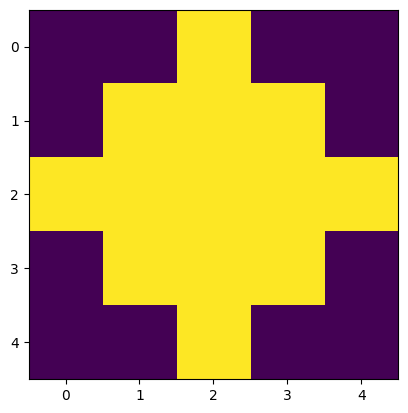

In [318]:
plt.imshow(ac_to_bc)

In [320]:
bc_res = 100
ac_res = 100

activity_bc = jnp.zeros((bc_res, bc_res))
activity_ac = jnp.zeros((ac_res, ac_res))

In [321]:
def vectorfield_bc(activity_bc, activity_ac):
    input_current_bc = convolved_signal  # Need to adjust dimensions
    input_current_bc -= activity_bc  # Decay term

    output_current_ac = convolve2d(activity_ac, ac_to_bc)
    input_current_bc -= output_current_ac
    return input_current_bc


def step_bc(activity_bc, activity_ac):
    rate_of_change = vectorfield_bc(activity_bc, activity_ac)
    activity_bc = activity_bc + dt * rate_of_change
    return activity_bc


def vectorfield_ac(activity_ac, activity_bc):
    input_current_ac = -activity_ac  # Decay term

    output_current_bc = convolve2d(activity_bc, bc_to_ac)
    input_current_ac -= output_current_bc
    return input_current_ac


def step_ac(activity_ac, activity_bc):
    rate_of_change = vectorfield_ac(activity_ac, activity_bc)
    activity_ac = activity_ac + dt * rate_of_change
    return activity_ac